# Signal Prediction with RNN

_By Donovan Lo, Booz Allen Hamilton_
( lo_donovan@bah.com )

####  https://github.com/DonovanLo/Signal-Prediction-RNN

### Tutorial Overview

Signal prediction has been heavily studied in multiple disciplines and exercised in many forms. Given some prior historic data, prediction allows us to determine the future and make better decisions. Current prediction approaches includes regression (discrete, linear, non-linear), time series models (ARIMA, Hidden Markov) and machine learning models  (neural network, SVM, K-NN). One machine learning approach that grew in popularity amongst practitioners and researchers due to the demand of predictive analytics and evolution of graphic processing units (GPU) , is Recurrent Neural Network. 

In this tutorial, you will learn: 

1. What is Recurrent Neural Network ? 
2. How RNN infer and learn from data samples ?
3. How to define the RNN architecture for your application ?
4. How to implement an RNN for signal prediction in Keras ?

<img src="./images/front.png">

### Import modules

This tutorial is written in [Python 3](https://www.python.org/downloads/), and uses [Keras](https://keras.io/) (2.0.0 or higher) with TensorFlow GPU (1.4.0 or higher) as backend. Other Python libraries that are used in this tutorial includes NumPy.

If you own a NVIDIA GPU, you can follow the installation guide on [TensorFlow GPU support](https://www.tensorflow.org/install/gpu) to learn how to take advantage of the GPU's capabilities. For those do not have a NVIDIA GPU, don't worry. You can also run this tutorial on your CPU as well. 

In [17]:
import numpy as np
import keras
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import RNN, Input, LSTM, Dropout, Embedding, TimeDistributed, Dense, Activation
from keras.layers import SimpleRNNCell, LSTMCell, GRUCell
from IPython.display import SVG
from tools import genSignal, plot_prediction

## 1.  Introduction
------------------

In this tutorial, we will learn how to create a Recurrent Neural Network (RNN) to predict a latter portion of a randomly generated sine and cosine signal segment, given the former half of the segment. 

First, let's play a game that you may be familiar with called "Catch Phrase". Don't worry if don't know the rules, you will learn it pretty quickly. You get a point for every word or word phrase you guess correctly, and you win once you score more than 7 points. I will be on your team as your clue-giver. Here it goes: 

1. Yo, ________
2. I feel the need - the need for _______
3. I'll be ________
4. Life is like a box of __________
5. I'll make him an offer he can't ________
6. Say hello to my little ________
7. My ___________
8. There is no place like _______
9. Houston, we have a __________
10. A martini. Shaken, ________

Hopefully you were able to guess majority of it. The answers are further down in the reading. In this game, we explored some of the properties of RNN. How so, you may ask. As you read each word in each of the clues, you build the context of the phrase from the previous words given and your exposure to the phrase. Each word that you read persist and gives you a different context for your guess. 

In traditional neural network, this is a difficult problem. For example, a neural network with a single word input would not be able to retain the previously seen words in sequential order to successfully guess the word/word phrase.

The one word input would only be mapped by the Neural Network to a predicted word, and each consecutive predicted word then can be fed in to Neural network. Neural network is limited by it's architecture and it's inability to allow information to persist.  Luckily, Recurrent Neural Network address NN's short-comings. 

Here is a good time to take a quick break and see if you got all the Catch Phrase lines correctly. 

__Answers__
1. Andrian (Rocky, 1976)
2. speed (Top Gun, 1986)
3. back (Terminator, 1984)
4. chocolate (Forrest Gump, 1994)
5. refuse (The Godfather, 1972)
6. friend (Scarface, 1983)
7. precious (The Lord of the Rings: Two Tower, 2002)
8. problem (Apollo 13, 1995)
9. no stirred (Goldfinger, 1964)

## 2. What is Recurrent Neural Networks ?
------------------

Recurrent Neural Network is a favor of Neural Network where the hidden state (or "understanding") at the current step is fed back in to the network to influence the next steps hidden state. This design in the architecture allows for sequential information to persist. The _recurrent_ in the name of RNN, refers to the repetitive passes that each hidden state derived from the input sequence is fed back to the network. This is the same case, if each word in the Catch Phrase clue were given to you (the RNN) one at a time.  

<img src="./images/Unfolded_Diagram.jpg">

Above is a RNN that is unfolded out by its timestep inputs. When we unfold the network, we are examing each of the input passes from the complete input sequence. For example, if the clue of 3 words, the unfolded network will contain 3-layers. To understand the RNN a little more in detail, lets review the components involved: 

Let's assume we have the following input:     

                            "Life is like a box of ______ "

- $x_t$ : input at timestep _t_. In our game example, the $x_t$ would be the encoded words (one-hot vector) in the phrase. For example, $x_1$ might be "1000" for the word "Life", $x_2$ be "0100" for the word "is", and so on.  
- $s_t$ : hidden state at timestep _t_. This is the state that the network is in after the network has received _t_ number of words from the input sequence. The state $s_t$ is calculated by the previous hidden state, $s_{t-1}$ and current word input, $x_t$ in the formula $s_t = f( U x_t + Ws_{t-1} )$. The function $f()$ is non-linear (tanh or ReLU) that pushes the values towards the range ends of -1 or 1. 
- $o_t$ : output at step _t_. The output is a vector of probabilities with each associated to one of the words in the defined vocabulary. The vector of probabilities are fed to a softmax() function to decide which vocabulary prevails as the predicted word. The formula for $o_t$ is $o_t = softmax(Vs_t)$ .
- U,W,V : _U_ is the weight matrix for the input. _W_ is the weight matrix for the state. _V_ is the weight matrix for the output. These weight matrices are updated during the backpropogration. 

Let's exercise the formula further in the next section. 

## 3. Forward Propogation
------------------

Forward propogation is also known as inference. When we infer, input values are passed through to the RNN to predict our word/word phrase. The vocabulary that we have includes [ life, is, like ]. Below is our entire vocabulary encoded. 

<img src="./images/Input.jpg">

Let's pass "Life" and "is" through the RNN and predict the third word. The encoded vector representing the first word "Life", is matrix multiplied with the weight _U_, to calculate _U * $x_1$_ . 

<img src="./images/Weight_Input.jpg">

To get the current hidden state, not only do we need the input's influence _U * $x_1$_, we would also need the previous hidden state knowledge _W * $s_0$_ . $s_0$ is the previous hidden state, but since there is no knowledge of any words we can initialize the weights as zeroes.  

<img src="./images/Weight_hidden.jpg">

We will get the current hidden state by $s_1 = tanh( U x_1 + W s_0 )$

<img src="./images/Next_State.jpg">

To predict the second word, we can take the current hidden state and perform a matrix multiplication with the output weights _V_. 

<img src="./images/Output.jpg">

The output probability vector $o_1$ at the current timestep is then fed to a softmax() function to decide which word in the defined vocabulary prevails. In this case, $o_1$ results in the word "_is_" . 

Each of the input words will produce a new hidden state and output. Below is the RNN that takes in the input sequence "Life is" and predicts the third word "like". 

<img src="./images/State_Diagram.jpg">






## 4. Back propagation
------------------

So how do we update the weights U, W, V to influence the model’s prediction ? This is addressed by the process called back-propagation. In some literature, you will see it be referenced as Back propagation in Recurrent Neural Network (BPTT). The word Back in back propagation refers to the process of going back in time in each unfolded layer to update the weights. 

The back propagation is like the standard back propagation in traditional Neural Network, however it takes a series of partial derivative for all time steps instead of just the current time step. For example, in order to take the gradient at t = 3 we would have to apply the chain rule and take 2 partial derivatives back to the first input at t = 0. 

Let’s define a loss function to allow for our correction in the weights. In this example, we will utilize the cross entropy loss Et(). In this formula, $\hat{o_t}$ is the predicted word at time t, $o_t$ is the target word at time t, and E() is the total error that sums each error in the time step. 

$$ E_t(o_t, \hat{o_t}) = -o_t\ log\ \hat{o_t} \\$$
$$ E(o, \hat{o}) = \sum_{t} E_t(o_t, \hat{o_t}) \\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = \sum_{t} -o_t\ log\ \hat{o_t} $$

Recall that the equation for the current hidden state is $s_t = tanh( U x_t + W s_{t-1})$ . In order for us make the proper update, we will need to take the gradients of the error with respect to our weights U, V, W . The gradients of the error will require us to sum up the gradients at each time step. 

In the diagram below, the RNN is unfolded for each of the time step. The red arrow depicts the chain rule to calculate the gradient from t to 0 with respect to the weights _U, V, or W_.

<img src="./images/BackPropagation_Diagram.jpg">

Let's look at $E_2$ in the example. To get the gradient for $E_2$ with respect to weight V, we will use the predicted output $\hat{o_2} = softmax(Vs_2)$ that consist V. From $\hat{o_2}$, we can define $z_2$ as $z_2 = Vs_2$ and take the derivative with respect to V. This only calculates the gradient when t=2. In order to calculate the gradient of the error to update the weights, we will need to sum up all the gradients at each time step from t to 0. 

$$ \frac{dE_2}{dV} = \frac{dE_2}{d\hat{o_2}} \frac{d\hat{o_2}}{dV} = \frac{dE_2}{d\hat{o_2}} \frac{d\hat{o_2}}{dz_2} \frac{dz_2}{dV},\ \ where\ z_2 = Vs_2$$
$$ so,\ \frac{dE}{dV} = \sum_{t}\ \frac{dE_t}{d\hat{z_t}} \frac{d\hat{z_t}}{dV} $$

In the same manner, let's take a look at taking the gradient for $E_2$ with respect to weights _W and U_. Unlike the gradient w.r.t weights _V_, the gradient of error w.r.t _W and U_ uses the hidden state equation $s_t = tanh(Ux_t+Ws_{t-1})$. Since the derivative of $s_t$ w.r.t _W_ is dependent on the previous $s_{t-1}$, we would need to apply the chain rule. 

$$ \frac{dE_2}{dW} = \frac{dE_2}{dz_2} \frac{dz_2}{ds_2} \frac{ds_2}{ds_1} \frac{ds_1}{dW} $$
$$ \frac{dE_2}{dU} = \sum_{k=1}^{t+1} \frac{dE_2}{ds_2} \frac{ds_2}{ds_1} \frac{ds_1}{dU} $$

Below is the gradient of error with each time step incorporated. 

$$ \frac{dE}{dW} = \sum_{t} \sum_{k=1}^{t+1} \frac{dE_{t+1}}{dz_{t+1}} \frac{dz_{t+1}}{ds_{t+1}} \frac{ds_{t+1}}{ds_k} \frac{ds_k}{dW} $$
$$ \frac{dE}{dU} = \sum_{t} \sum_{k=1}^{t+1} \frac{dE_{t+1}}{dz_{t+1}} \frac{dz_{t+1}}{ds_{t+1}} \frac{ds_{t+1}}{ds_k} \frac{ds_k}{dU} $$

If you would like to read more on the math behind back propagation, you can review the following paper [A Gentle Tutorial of Recurrent Neural Network with Error Backpropagation](https://arxiv.org/pdf/1610.02583.pdf).

## 5. RNN Input and Output
------------------

We have seen that Recurrent Neural Network can receive a sequence of words as the input and predict a single word, but a RNN can have sequences as an input, and/or output. Below is a list of different RNNs with sequence as input, output, neither, or both. 

<img src="./images/input_output.png">
[Source](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

The blocks in red are Input vectors, green are the RNN's hidden state, and blue are the Output vectors. The arrows indicate the forward propagation. 

- __One to One__: This is what you see in traditional Neural Network. Fixed-sized input to Fixed-sized output. (e.g. vector or image classification)
- __One to Many__: Fixed-sized input to Sequence output. (e.g. Image captioning. Given an image with fixed dimension, a RNN can output a sequence of words.)
- __Many to One__: Sequence input to Fixed-sized output. (e.g. Sentiment analysis. Given a sequence of words, a RNN can classifier the sentiment of the text as sad, happy, persausive.)
- __Many to Many__: Sequence input to Sequence output. (e.g. Machine translation. Given sequence of english words, a RNN can translate the text to it's respecitive spanish words.)
- __Many to Many (Synced)__: Synced Sequence input to Sequence output. (e.g. In Video classification, each frame in a video is fed in to the RNN in which it predicts each class. )

Can you guess which of these Speech Recognition (audio to text) falls under ?

### Explore our signal data

Before we start implementing our RNN for our signal predictor, we need to understand our input data. Although signals can be seen in many forms such as electromagnetic (optical, radio frequency tranmissions), electrical signal (current ,voltage signatures) , and vibration (sound, sonar), they all share the same core principle which is a measurment captured with time. 

In this tutorial, we will use a generic sine and cosine generator to randomly create our signals. The signal generator is written in a separate python script called _tools.py_, which we will call it's methods _genSignal()_ and _plot_prediction()_. 

The _genSignal()_ method can create one of the three different types of signals. Each can be called by giving the index respective to the signal you would like to generate. For example, _genSignal\[1\]()_ to createa sine wave generator. 

1. Sine wave
2. [Superposition](https://en.wikipedia.org/wiki/Superposition_principle) of sine and cosine wave
3. Superposition of sine and cosine wave with noise added

Here are samples of the 3 different signal types.  

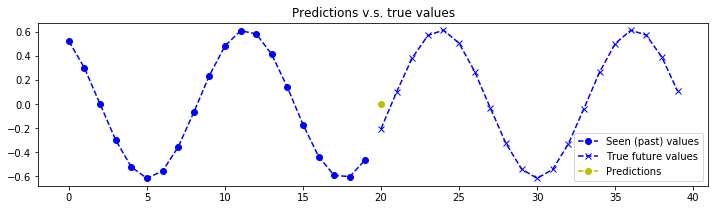

In [18]:
epoch_step_size = 1
batch_size = 1
data_generator = genSignal[1](epoch_step_size, batch_size, input_len=20, output_len=20)
(x_encoder_data, x_decoder_data), y_data = next(data_generator)
plot_prediction(x_encoder_data[0, :, :], y_data[0, :, :],x_decoder_data)

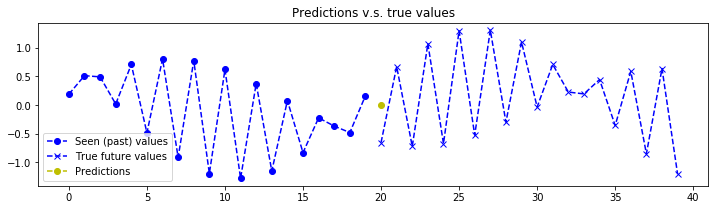

In [19]:
epoch_step_size = 1
batch_size = 1
data_generator = genSignal[2](epoch_step_size, batch_size, input_len=20, output_len=20)
(x_encoder_data, x_decoder_data), y_data = next(data_generator)
plot_prediction(x_encoder_data[0, :, :], y_data[0, :, :],x_decoder_data)

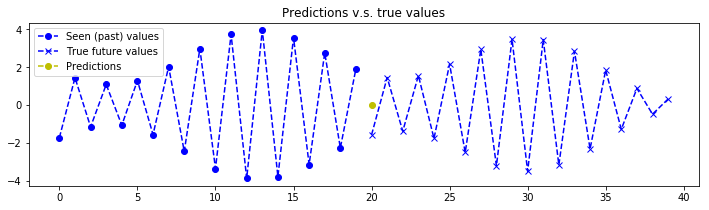

In [20]:
epoch_step_size = 1
batch_size = 1
data_generator = genSignal[3](epoch_step_size, batch_size, input_len=20, output_len=20)
(x_encoder_data, x_decoder_data), y_data = next(data_generator)
plot_prediction(x_encoder_data[0, :, :], y_data[0, :, :],x_decoder_data)

Each of the input _x_ is an array containing 15 values, and the targeted output _y_ is also 15 values. Since the input is a sequence of values and the output is also a sequence of values, we will use the many-to-many RNN. The many-to-many RNN is also called seqenece-to-sequence (or seq2seq). 

## 6. Seq2Seq Model
------------------

The Seq2Seq model uses an encoder-decoder model architecture. 

- __Encoder__ : Encoder is neural network that takes a time-series input, iterates through each time-step input and encodes the sequence into a context vector. 
- __Decoder__ : Decoder is also a neural network. Unlike the encoder, it takes the compresed context vector and upsamples the encoded inputs to its sequence form. 

As the authors in the [Sequence to Sequence Learning paper](https://arxiv.org/pdf/1409.3215.pdf) describes, although Deep Neural Network ([DNN](https://arxiv.org/abs/1404.7828)) are powerful, DNN are limited by it’s fixed input and output dimensionality and requires a large amount information to specify the network’s parameters. 

At a high level, the encoder updates it’s hidden state for each value read from the input sequence using a RNN (with LSTM or GRU) and outputs an encoded state (vector). This encoded state is the neural network’s compressed representation of the input sequence. The decoder takes the encoded state as it’s initial hidden state, and updates it for each output value predicted. 

<img src="./images/Encoder-Decoder.jpg">

Modified [Source](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md])

Above is a diagram of the encoder-decoder architecture. In the diagram, the RNN receives the first three even values (2,4,6) and attempts to predict the next three (8,10,12). Notice that the encoder uses the same RNN through the input iteration. Likewise, the decoder uses the same RNN through the output iteration, but it's architecture is slightly different from the encoder's. 

## Implement Encoder-Decoder (Seq2Seq) model

The code implementation in this tutorial is credited to [Luke Tonin](https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction) who took inspiration from [G. Chevalier](https://github.com/guillaume-chevalier/seq2seq-signal-prediction) and [F. Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) and did a great job explaining the Seq2seq model. 

### Hyperparameters

Let's implement the encoder and the decoder using python's package [Keras](https://keras.io/). Before we start building out the two components, we will define the hyperparameters that charaterizes our model including training set size, input/output length, encoder/decoder architecture. 

If you're interested in modifying the Encoder/Decoder's optimizer, you can take a look at [Keras' optimzers](https://keras.io/optimizers/) section. In this tutorial, we will use the Adam optimizer but there are other optimizers (SGD, RMSprop, Adagrad, Adadelta, Adamax, and Nadam) that you can experiment with. 

Similarly, if you would like try a different loss (error) function to calculate the gradient you can take a look at [Keras' losses](https://keras.io/losses/) section. In this tutorial, we will be using the _mean squared error_ loss function. 

In [5]:
keras.backend.clear_session()

# RNN flavors (SimpleRNN, LSTM, GRU)
rnn_type = 'SimpleRNN'

rnn_cell_dict = { 'SimpleRNN': SimpleRNNCell,
               'LSTM': LSTMCell, 
               'GRU': GRUCell
           }
rnn_cell = rnn_cell_dict[rnn_type]

# Training set size
batch_size = 512      # The number of sequences to be generated and trained in a batch.
epoch_step_size = 200 # batch_size * epoch_step_size = total number of training examples.
epochs = 15           # The number of times to iterate over the entire training set in training process.

# Input and output length
input_sequence_length = 10 # Length of the sequence used by the encoder
target_sequence_length = 10 # Length of the sequence predicted by the decoder

# Encoder/Decoder architecture 
num_input_features = 1
num_output_features = 1
learning_rate = 0.01
lr_decay = 0 
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=lr_decay)
loss = "mse"
lambda_regulariser = 0.000001
regulariser = None 

# Create keyword args for RNN cells
cell_args = {
        "kernel_regularizer": regulariser,
        "recurrent_regularizer": regulariser, 
        "bias_regularizer": regulariser
}

### Implement the Encoder

In Keras, we will create the encoder by specifying the RNN cell instance. In Keras, the [RNN cell instance](https://keras.io/layers/recurrent/) refers to the type of RNN that you would like to use (simpleRNNCell, GRUCell, or LSTMCell). 

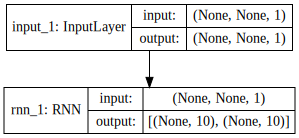

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
rnn_1 (RNN)                  [(None, 10), (None, 10)]  120       
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


None

In [6]:
# Define size of input sequence. 
encoder_inputs = Input(shape=(None, num_input_features))

# Create each RNN layer for the Encoder. Each RNN layer is fed to each 
# other to stack the RNN encoder. 
encoder_cells = []
encoder_cells.append( rnn_cell(units=10, **cell_args) )
#encoder_cells.append( rnn_cell(units=20, **cell_args) )
encoder = RNN(encoder_cells, return_state=True)

# The RNN encoder will return an output (2D tensor) and the states (list
# of tensors). We will only keep the states returned from the encoder to 
# initialize the decoder's states. 
encoder_results = encoder(encoder_inputs) 
encoder_states = encoder_results[1:]

# To visualize the encoder
encoder_predict_model = Model(encoder_inputs, encoder_states)
display( SVG(model_to_dot(encoder_predict_model, show_shapes=True).create(prog='dot', format='svg')) )
display(encoder_predict_model.summary())

### Implement the  Decoder

In [7]:
# Define the decoder's input size.
decoder_inputs = Input(shape=(None, num_input_features))

# Create each RNN layer for the Decoder. Each RNN layer is fed to each 
# other to stack the RNN dencoder. 
decoder_cells = []
decoder_cells.append(rnn_cell(10, **cell_args))
#decoder_cells.append(rnn_cell(20, **cell_args))
decoder = RNN(decoder_cells, return_sequences=True, return_state=True)

# We will initialize the decoder's states with the encoder's final state.
# The RNN decoder will also return an output and it's final states, but 
# we only care about the output from the decoder. We will omit the returned
# states from the decoder. 
decoder_results = decoder(decoder_inputs, initial_state=encoder_states)
decoder_outputs = decoder_results[0]

decoder_dense = Dense(num_input_features,
                        activation='linear',
                        kernel_regularizer=regulariser,
                        bias_regularizer=regulariser)
decoder_outputs = decoder_dense(decoder_outputs)

### Implement Encoder-Decoder model

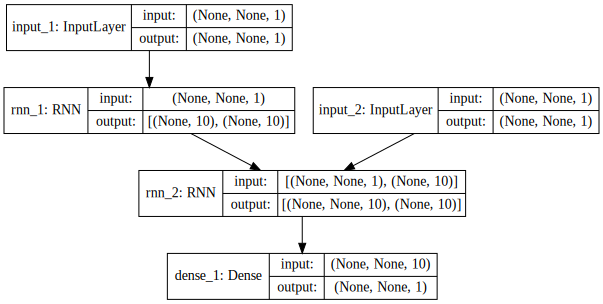

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
rnn_1 (RNN)                     [(None, 10), (None,  120         input_1[0][0]                    
__________________________________________________________________________________________________
rnn_2 (RNN)                     [(None, None, 10), ( 120         input_2[0][0]                    
                                                                 rnn_1[0][1]                      
__________

None

In [8]:
model = Model(inputs=[encoder_inputs, decoder_inputs],outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)

# To visualize model
display( SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')) )
display(model.summary())

### Train the model

In [9]:
train_data_generator = genSignal[1](epoch_step_size, batch_size, input_sequence_length, target_sequence_length)
model.fit_generator(train_data_generator, steps_per_epoch=epoch_step_size, epochs=epochs)

Epoch 1/15
200/200 [==============================] - 2s 11ms/step - loss: 0.1932

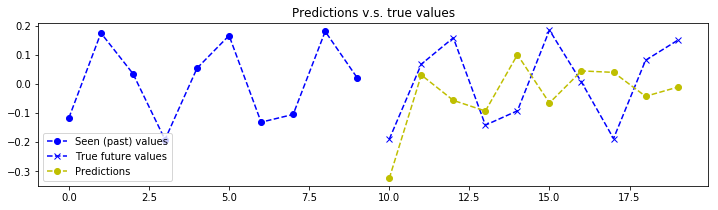

In [10]:
test_data_generator = genSignal[1](epoch_step_size, batch_size, input_sequence_length, target_sequence_length)

(x_encoder_test, x_decoder_test), y_test = next(test_data_generator) 

y_test_predicted = model.predict([x_encoder_test, x_decoder_test])
plot_prediction(x_encoder_test[0, :, :], y_test[0, :, :], y_test_predicted[0, :, :])

When we make a predictions, the model can only predict a sequence with the length of what we have trained it. If we would like to predict further in the timestep, we would need to loop through the decoder more. 

### Create Prediction model of arbituary length

We need to setup our inference model for prediction. In our training, the encoder's and decoder's layers were created and coupled together in to a single Keras model. That Keras model iterates through the inpute sequence and creates a encoded state, in which then is passed to the decoder to predict for each value in the fixed target sequence. Like-wise , when that same Keras model is used for prediction it will predict up to the trained target sequence length. 

In this section, we will modify the model so a dynamic number of values will be outputed in the predicted sequence. The encoder and it's weights are retained from training and made a separate Keras model. To implement the decoder as a Keras model, we will load the decoder's architecture including it's input, layers, and output from training. 

__NOTE__: If the model contains multiple layers, the Keras decoder model is built by reading the layers backwards. For example, if the trained model has [10, 20] units in the first two layers, the decoder model will be [20, 10]. 

In [11]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_states_inputs = []
# The model's states are read backwards to conform with the inference format. 
# For example, state in first layer is now last. 
if rnn_type == 'LSTM':
    # Second LSTM Layer
#     decoder_state_input_h = Input(shape=(20,))
#     decoder_states_inputs.append( decoder_state_input_h )
#     decoder_state_input_c = Input(shape=(20,))
#     decoder_states_inputs.append( decoder_state_input_c )
    # First LSTM layer
    decoder_state_input_h = Input(shape=(10,))
    decoder_states_inputs.append( decoder_state_input_h )
    decoder_state_input_c = Input(shape=(10,))
    decoder_states_inputs.append( decoder_state_input_c )
else:
    # Second SimpleRNN/GRU layer
    #decoder_states_inputs.append( Input(shape=(20,)) )
    # First SimpleRNN/GRU layer
    decoder_states_inputs.append( Input(shape=(10,)) )

# Create the decoder 
decoder_results = decoder( decoder_inputs, initial_state=decoder_states_inputs )
# Extract the output and the state from the decoder
decoder_outputs = decoder_results[0]
decoder_states = decoder_results[1:]
# Add dense layer after the output of decoder
decoder_outputs = decoder_dense(decoder_outputs)
decoder_predict_model = keras.models.Model( [decoder_inputs]+decoder_states_inputs, [decoder_outputs]+decoder_states)

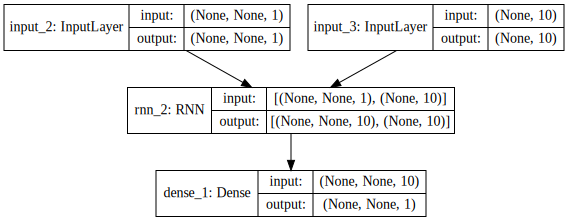

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
rnn_2 (RNN)                     [(None, None, 10), ( 120         input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 1)      11          rnn_2[1][0]                      
Total para

None

In [12]:
display( SVG(model_to_dot(decoder_predict_model, show_shapes=True).create(prog='dot', format='svg')) )
display(decoder_predict_model.summary())

Now that we have defined the encoder and decoder's Keras model, we can create a method to receive an input sequence and predict a output sequnece of a length of our choice. In the method:
1. Encode the input sequence to a state for the decoder to initialize. 
2. In the first timestep, the decoder intialize it's state, receives an arbitrary input, and outputs a predicted value
3. The predicted value is added to the output sequence. 
4. The decoder's input and state updates and process repeats for number of steps defined.   

In [13]:
def decode_sequence(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    # Encode input sequence 
    states = encoder_predict_model.predict(x)
    # The states must be a list
    if not isinstance(states, list):
        states = [states]
    # Create empty sequence initialize decoder's first input
    decoder_input = np.zeros((x.shape[0], 1, 1))

    y_predicted = []
    # Loop through each output of the decoder until the length of the output sequence
    # meets the user's demand. 
    for _ in range(num_steps_to_predict):
        # Get the output and the states at timestep t. Store each output value in to the predicted sequence.
        outputs_and_states = decoder_predict_model.predict([decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

### Predict signal of an arbitrary length

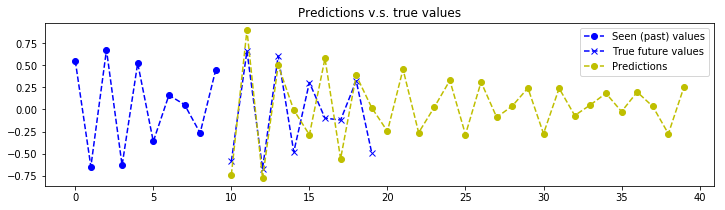

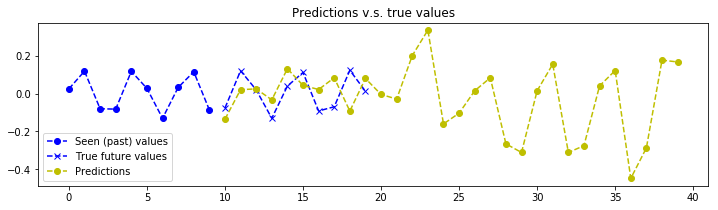

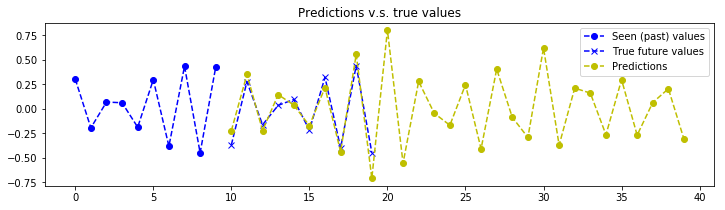

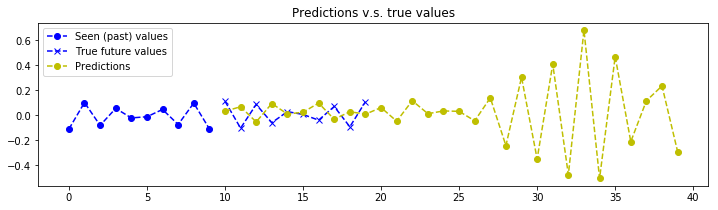

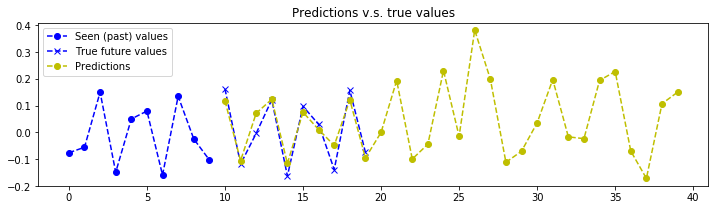

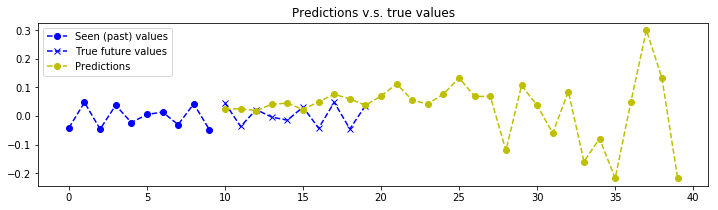

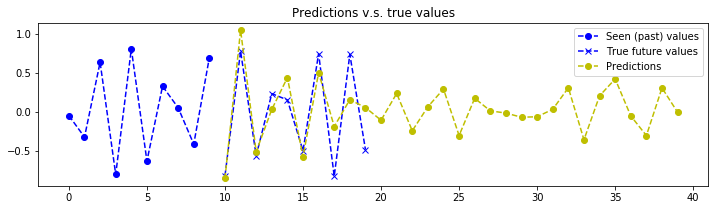

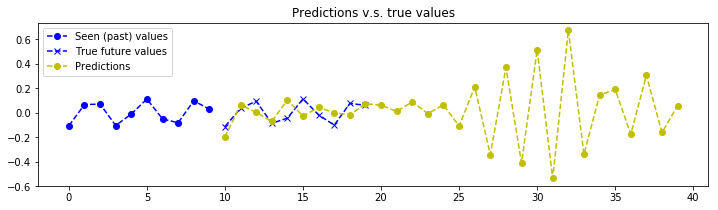

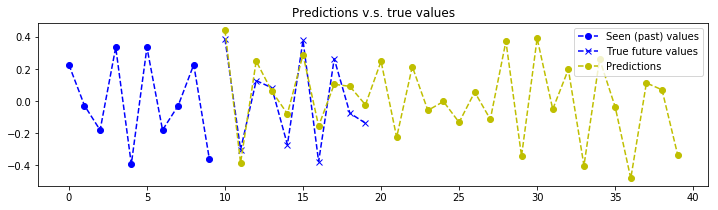

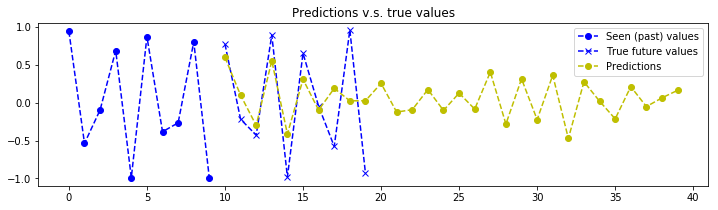

In [14]:
arb_length = 30

test_data_generator = genSignal[1](epoch_step_size, batch_size, input_sequence_length, target_sequence_length)
(x_test, _), y_test = next(test_data_generator)

y_test_predicted = decode_sequence(x_test, encoder_predict_model, decoder_predict_model, arb_length) 

# Choose 10 random test
indices = np.random.choice(range(x_test.shape[0]), replace=False, size=10)

for index in indices:
    plot_prediction(x_test[index, :, :], y_test[index, :, :], y_test_predicted[index, :, :])

From some of the predictions for a SimpleRNN 

### Evaluate Predictions

To evaluate our time series prediction, we can apply MAPE, MAD, RMSE, or MSE. [Rob Hyndman's website](https://otexts.com/fpp2/accuracy.html) some of the techniques to evaluate forecast accuracy. 

In [15]:
# Root mean square error
def rmse(y, y_predict):
    return np.sqrt( np.mean( np.square( y - y_predict )) )

# Mean absolute percentage error
def mape(y, y_predict):
    return np.mean( abs( (abs(y - y_predict)/y) * 100) )

In [16]:
(x_test, _), y_test = next(test_data_generator)
y_test_predicted = decode_sequence(x_test, encoder_predict_model, decoder_predict_model, arb_length) 

m = min(len(y_test[0]),len(y_test_predicted[0]))
error = 0
for i in range(len(y_test)):
    error += rmse(y_test[i][:m], y_test_predicted[i][:m])
error = error/len(y_test)
print('Error: {}'.format(error) )

Error: 0.2550492199897451


## 7. Summary 
------------------

- We learned what a Recurrent Neural Network is and how it performs forward and back propagation. 
- We examined the different input and output architectures of RNN to allow us choose the appropriate favor for our application. 
- In particular, we explored and implemented a Sequence-to-Sequence model to predict a generic signal sequence using Keras. 

## 8. Next Steps
------------------

### - Test the RNN on different signal type

Explore the other signal types including the superposition, and superposition with noise. This can be easily changed in the _genSignal\[index\]()_ method by giving it 1, 2, or 3 as the index. Other signal types will give you a better idea on the shortcomings in the RNN model and allow you to make the proper adjustments in the model. 

### - Modify different number of neurons and the number of layers in the RNN

Why stop at 10 neurons for 1 layer in the encoder and decoder ? Try changing the size of the RNN's architecture by adding more Keras' layers from [ 10 ] to something else such as [ 10, 20 ] for a 2 layer network with 10, 20 units. Similar to traditional NN, increasing the number of hidden layers might improve accuracy depending on complexity, but also may cause the network to overfit. The Keras's [Model (functional API)](https://keras.io/models/model/) and [Core Layers](https://keras.io/layers/core/) documentation will help with manipulating the network's layers. 

### - Apply GRU or LSTM

In the tutorial, we reviewed and applied a Fully-connected RNN in the model. Traditional RNN are limited in learning "long-term dependencies" ([vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)) indicated by [Bengio et al](http://ai.dinfo.unifi.it/paolo//ps/tnn-94-gradient.pdf) and would only predict values based on recent information. To solve the "long-term dependencies" deficiency, replace the __rnn_type__ from _SimpleRNN_ to [GRU](https://arxiv.org/pdf/1406.1078v3.pdf) or [LSTM](http://www.bioinf.jku.at/publications/older/2604.pdf). 

GRU vs LSTM
- GRU has two gates (Reset, Update). LSTM has three gates (Forget, Input, Output). 
- GRU don’t posses internal memory C(t) and No output gate like LSTM
- Input and Forget gates are coupled by an update gate
- Reset gate is applied directly to previous hidden state
- GRU have fewer parameters (U and W are smaller) , thus train a bit faster or need less data to generalize
- LSTM may be more expressive

<table><tr><td><img src="./images/RNN_simple.png"></td><td><img src="./images/LSTM.png"></td><td><img src="./images/GRU.png"></td></tr></table>
<center>[Source](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (Left: SimpleRNN, Middle: LSTM, Right: GRU)</center>

### - Apply Attention

During the encoding, the input sequence is compressed in to a fixed size vector representation of the network’s understanding may result in some information loss. A mechanism that you may try as your next step is applying Attention. Attention addresses the issue by focusing on local or global features that provides a richer context to the encoded vector. 

There is a brief mention on using attention in Keras’ documentation, under [Note on specifying the initial state of RNNs](https://keras.io/layers/recurrent/) as passing an external constant. You may look in to Github project called [keras-attention-mechanism](https://github.com/philipperemy/keras-attention-mechanism) and [keras-attention](https://github.com/datalogue/keras-attention). 

## 9. Further Reading
------------------

### RNN
- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

### LSTM
- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### GRU
- [Understanding GRU Networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)

### Attention 
- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
- [Recurrent Models of Visual Attention](https://arxiv.org/abs/1406.6247)
- [Grammar as a Foreign Language](https://arxiv.org/abs/1412.7449)
- [Attention Mechanism](https://blog.heuritech.com/2016/01/20/attention-mechanism/)
- [End-To-End Memory Networks](https://arxiv.org/abs/1503.08895)

### Applications
- [DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks](https://arxiv.org/abs/1704.04110)
- [A Neural Conversational Model](https://arxiv.org/pdf/1506.05869v1.pdf)
- [Kaggle Web Traffic Time Series Forecasting](https://github.com/Arturus/kaggle-web-traffic)


## 10. Source
------------------
### https://github.com/DonovanLo/Signal-Prediction-RNN